<a href="https://colab.research.google.com/github/Mahadevan0507/Diabetes-Prediction/blob/main/Classification_of_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetes-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3102947%2F5344155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240714%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240714T053435Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D02dd5329e76bf3609a8b18b429a2150fa8dca19638483f424b772373cd68815936336d0d5c1715504f6839923dea77a01a2c102559f086aa254444532f6b8dc4548f46316f7ecd952ec9dd901689a4c67ea77bc5e43acd7abec4f890450f03d453ae03f2a83e0c617af2a9d6cd4762b116488c39c3e90c4b495ff0918ccda19a5c8f5a71f8a141a29218313b2632e0113c2e2b452cb3b81fcfead06dd798b8e5ed68249ced46022e208ac9aeb522c6a6a06fd715f8e4d738d0a8abae84facf7cf09560da8ac5ddd27ae7f50abc0dd4fdeb8be3b3ac30deb48fe2c5775b528346c79f97530f53b876d225a0b20829039bbc8819d94002acd2c67115d0496fc534'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 751272 bytes downloaded
Downloaded and uncompressed: diabetes-prediction-dataset
Data source import complete.


# Loading libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


# The purpose
The purpose of the task is to analyze the dataset and solve the problem of diabetes prediction qualification.

In [3]:
df=pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [5]:
df.drop(df.index[df['gender'] == 'Other'], inplace=True)

In [6]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

In [7]:
le = LabelEncoder()
df['smoking_history']= le.fit_transform(df['smoking_history'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99982 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  int64  
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  int64  
 3   heart_disease        99982 non-null  int64  
 4   smoking_history      99982 non-null  int64  
 5   bmi                  99982 non-null  float64
 6   HbA1c_level          99982 non-null  float64
 7   blood_glucose_level  99982 non-null  int64  
 8   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 7.6 MB


<Axes: xlabel='age', ylabel='Count'>

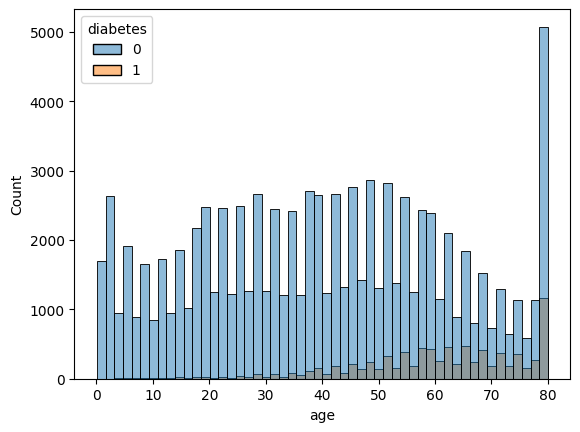

In [9]:
sns.histplot(data=df, x="age",hue='diabetes')

<Axes: xlabel='HbA1c_level', ylabel='Count'>

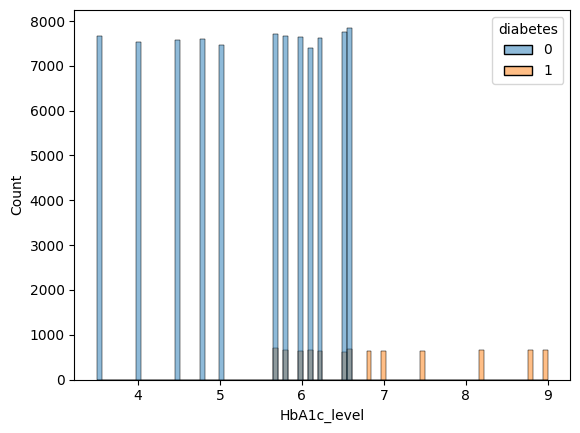

In [10]:
sns.histplot(data=df, x="HbA1c_level",hue='diabetes')

We can observe the following pattern:
- The older a person is, the higher the risk of diabetes
- HbA1c_level after a value of 6, the risk of diabetes is increased

<Axes: >

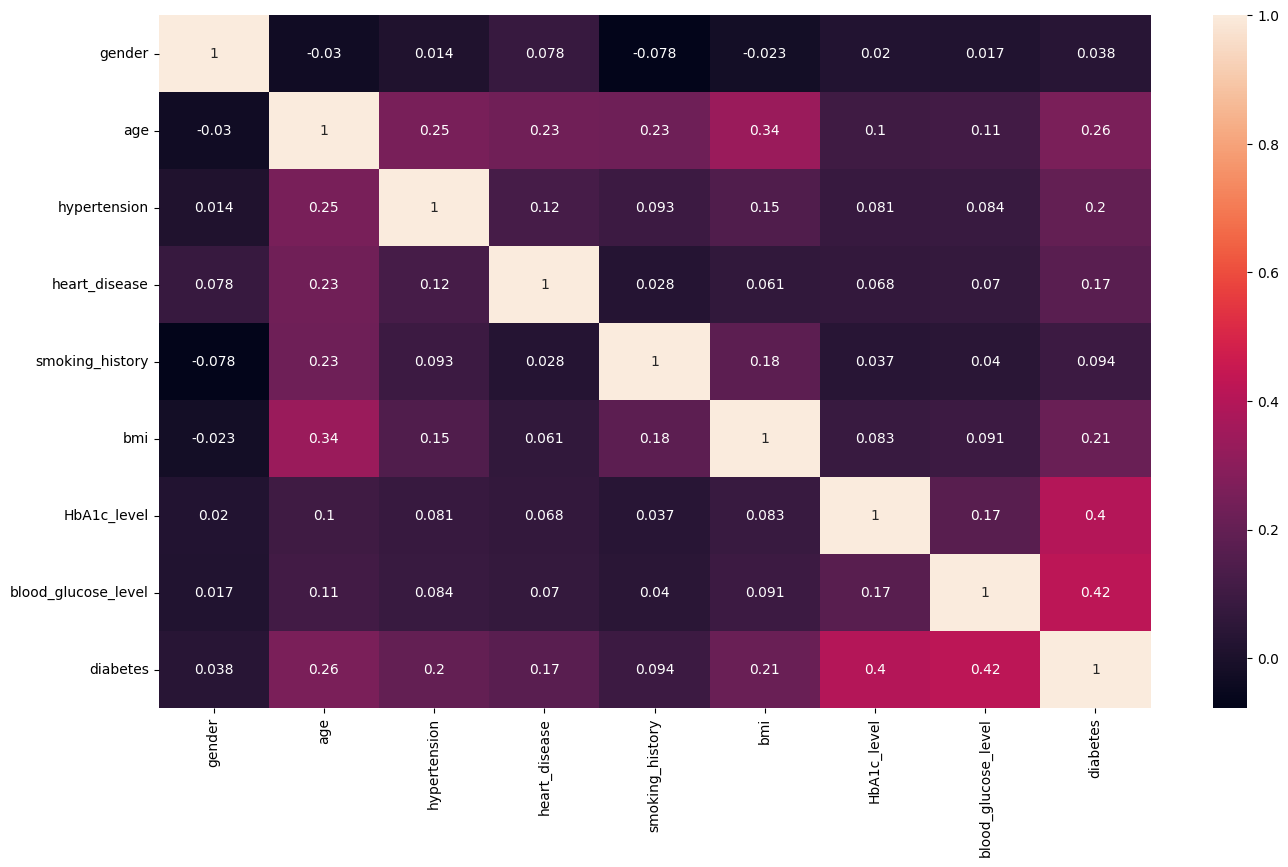

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [12]:
select_feature = df.corr()
select_feature = select_feature.index[abs(select_feature["diabetes"]) >= 0.2]
select_feature

Index(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'], dtype='object')

# Build Model

In [13]:
X = df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
y = df['diabetes']

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression 95.91%

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
train_accuracy = lr.score(X_train, y_train)
val_accuracy = lr.score(X_test, y_test)

print("Train Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(val_accuracy*100))

Train Accuracy: 96.02%
Test Accuracy: 95.91%


# Desicion Tree 97.08%

In [16]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 3, 5, 7],
    'criterion': ['gini', 'entropy']
}

decision_tree_model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model_tree= grid_search.best_estimator_

best_model_tree.fit(X_train, y_train)

train_accuracy = best_model_tree.score(X_train, y_train)
val_accuracy = best_model_tree.score(X_test, y_test)


print("Train Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(val_accuracy*100))

Train Accuracy: 97.21%
Test Accuracy: 97.08%


# RF 97.07%

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model_rf = grid_search.best_estimator_

best_model_rf.fit(X_train, y_train)

train_accuracy_rf = best_model_rf.score(X_train, y_train)
val_accuracy_rf = best_model_rf.score(X_test, y_test)
print("Train Accuracy: {:.2f}%".format(train_accuracy_rf*100))
print("Test Accuracy: {:.2f}%".format(val_accuracy_rf*100))

# Conclusion
We found that random forest and decision tree showed the best accuracy and the difference between them is minimal.
To continue the development of this topic, I suggest collecting more data and increasing the number of features